# Defect Detection

In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

In [2]:
# Load the dataset
df = pd.read_csv(r'C:\Users\njhar\Downloads\manufacturing data.csv',encoding='latin1')

# Display the first few rows to understand the dataset structure
print("Dataset Preview:")
print(df.head())

Dataset Preview:
   Product_ID Batch_Number Production_Date    Shift   Inspector_Name  \
0    66048763      BN-8115      08-01-2022  Evening       Ruth Avery   
1    47593824      BN-8570      08-01-2022    Night     Caleb Romero   
2    42194897      BN-3282      08-01-2022    Night     Sherry Smith   
3    24115780      BN-7240      08-01-2022    Night   Chad Mccormick   
4    15659385      BN-7023      08-01-2022  Evening  Elizabeth Jones   

  Defect_Type Pass_Fail  Dimension (mm)  Tolerance (mm)  \
0       Crack      Pass          117.77            0.73   
1   No_Defect      Fail          191.96            0.26   
2       Other      Fail          164.35            0.77   
3       Other      Pass           27.74            0.13   
4       Other      Fail           56.73            0.62   

   Production_Time (mins)  ...  Material_Used (kg)  Energy_Consumption (kWh)  \
0                      83  ...                0.45                    217.98   
1                      80  ...     

In [3]:
# Inspect and Prepare Data
# Define relevant features and target column
features = ['Temperature (°C)', 'Pressure (bar)', 'Production_Time (mins)']
target = 'Pass_Fail'

In [4]:
# Drop rows with missing values in the relevant columns
df = df.dropna(subset=features + [target])

In [5]:
# Encode the target variable (Pass/Fail) to numeric values
label_enc = LabelEncoder()
df['Pass_Fail_Encoded'] = label_enc.fit_transform(df[target])

In [6]:
# Split the dataset into features (X) and target (y)
X = df[features]
y = df['Pass_Fail_Encoded']

In [7]:
# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Handling the Class Imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [9]:
# Normalize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [10]:
# Hyperparameter Tuning with GridSearchCV
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],          # Reduced to two options for speed
    'max_depth': [10, 20],              # Keeping it manageable
    'min_samples_split': [2, 5],        # Simplified to reduce search space
    'min_samples_leaf': [1, 2]          # Simplified options
}
# Use GridSearchCV with reduced folds for larger datasets
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,  # Use 3-fold CV for faster results
    scoring='accuracy',
    verbose=2,  # Provides detailed logs for tracking progress
    n_jobs=-1   # Utilize all available CPU cores for parallelism
)
grid_search.fit(X_train_scaled, y_train_resampled)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='accuracy', verbose=2)

In [11]:
# Best model from GridSearchCV
best_model = grid_search.best_estimator_
print("\nBest Model Parameters:", grid_search.best_params_)


Best Model Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [12]:
# Evaluate the Model
# Predict on the test set
y_pred = best_model.predict(X_test_scaled)

In [13]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)


Confusion Matrix:
 [[482 512]
 [503 503]]


In [14]:
# Classification Report
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)


Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.48      0.49       994
           1       0.50      0.50      0.50      1006

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.49      0.49      0.49      2000



# Feature Importance

In [15]:
# Feature Importance
feature_importances = pd.DataFrame(
    {'Feature': features, 'Importance': best_model.feature_importances_}
).sort_values(by='Importance', ascending=False)
print("\nFeature Importances:\n", feature_importances)


Feature Importances:
                   Feature  Importance
0        Temperature (°C)    0.394459
1          Pressure (bar)    0.370526
2  Production_Time (mins)    0.235015


In [16]:
import joblib

# Save the trained model and scaler
joblib.dump(best_model, 'trained_defect_detection_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("\nModel and Scaler saved!")


Model and Scaler saved!


# Testing the New data


Classification Completed. Sample results:
    Product_ID Batch_Number Production_Date    Shift    Inspector_Name  \
0    23906228      BN-0737      20-02-2022    Night  Katherine Jensen   
1    61037588      BN-0737      06-09-2022    Night    William Gordon   
2    85735484      BN-0212      25-02-2024  Morning     Joseph Howard   
3    66015147      BN-2303      13-11-2022    Night  Christopher Nash   
4    81894154      BN-2303      10-07-2023  Morning    Jessica Parker   

      Defect_Type Pass_Fail  Dimension (mm)  Tolerance (mm)  \
0   Discoloration      Fail          121.31            0.24   
1   Discoloration      Pass          135.72            0.64   
2  Size Variation      Pass           53.44            0.34   
3  Size Variation      Fail          185.79            0.78   
4   Discoloration      Pass          111.76            0.96   

   Production_Time (mins)  ...  Energy_Consumption (kWh)  Quality_Score (%)  \
0                      64  ...                     26.19   

C:\Users\njhar\AppData\Local\Temp\ipykernel_19724\2454801790.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Random Forest_Predictions', data=classified_data, palette='coolwarm')


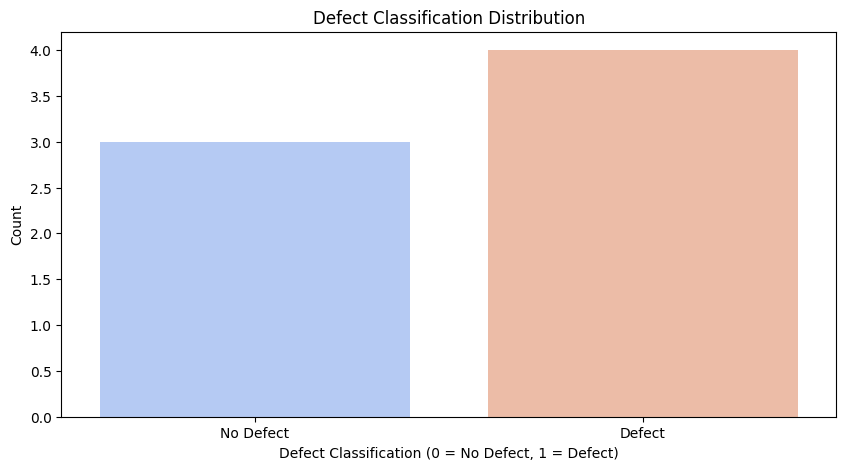

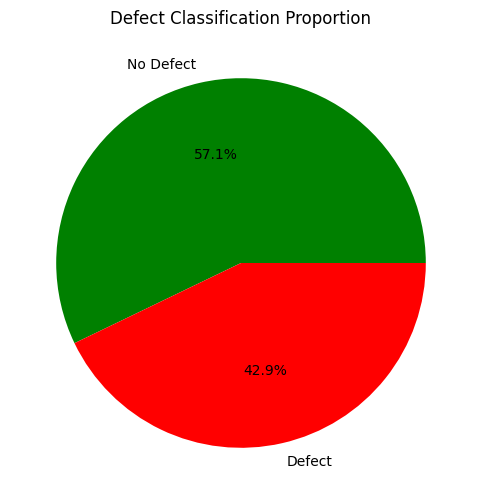

In [17]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the trained models
rf_model = joblib.load('trained_defect_detection_model.pkl')

# Define available models
available_models = {
    'Random Forest': rf_model,
}

# Load the scaler
scaler = joblib.load('scaler.pkl')

# Load the dataset for testing
df = pd.read_csv(r'C:\Users\njhar\Downloads\manufacturing data.csv', encoding='latin1')

# Preprocess the dataset as needed
features = ['Temperature (°C)', 'Pressure (bar)', 'Production_Time (mins)']
df = df.dropna(subset=features)  # Handle missing values

# Identify unique batch numbers and randomly select 5
batch_numbers = df['Batch_Number'].unique()
random_batches = np.random.choice(batch_numbers, size=min(5, len(batch_numbers)), replace=False)

# Function to classify randomly selected batches
def classify_batches(data, models, selected_batches):
    results_list = []

    for batch in selected_batches:
        specific_data = data[data['Batch_Number'] == batch]

        # Skip if there's no data for this batch
        if specific_data.empty:
            continue

        # Extract features and scale them
        specific_features = specific_data[features]
        specific_features_scaled = scaler.transform(specific_features)

        # Test the models on this specific data
        batch_results = specific_data.copy()
        for model_name, model in models.items():
            predictions = model.predict(specific_features_scaled)
            batch_results[f"{model_name}_Predictions"] = predictions

        results_list.append(batch_results)

    # Combine results into a single DataFrame
    if results_list:
        final_results = pd.concat(results_list, ignore_index=True)
        return final_results
    else:
        return None

# Run classification on randomly selected batches
classified_data = classify_batches(df, available_models, random_batches)

# Display results and visualize
if classified_data is not None:
    print("\nClassification Completed. Sample results:\n", classified_data.head())

    # Visualization - Count of defect vs non-defect
    plt.figure(figsize=(10, 5))
    sns.countplot(x='Random Forest_Predictions', data=classified_data, palette='coolwarm')
    plt.xlabel("Defect Classification (0 = No Defect, 1 = Defect)")
    plt.ylabel("Count")
    plt.title("Defect Classification Distribution")
    plt.xticks(ticks=[0, 1], labels=["No Defect", "Defect"])
    plt.show()

    # Pie chart for defect ratio
    defect_counts = classified_data['Random Forest_Predictions'].value_counts()
    plt.figure(figsize=(6, 6))
    plt.pie(defect_counts, labels=["No Defect", "Defect"], autopct='%1.1f%%', colors=['green', 'red'])
    plt.title("Defect Classification Proportion")
    plt.show()

else:
    print("No valid batch data found for classification.")
